### Imports
Import packages and load model parameters (uncertainties, levers, etc.)

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle

In [2]:
# make sure pandas is version 1.0 or higher
# make sure networkx is verion 2.4 or higher
print(pd.__version__)
print(nx.__version__)

1.4.2
2.8.2


In [3]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation


def sum_over(*args):
    return sum(args)

In [4]:
# Enable logging
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

**Problem formulation**
Important cell below, here you can choose the problem formulation number, between 0-5
each problem formulation has its own list of outcomes

In [5]:
used_problem_formulation = 2

dike_model, planning_steps = get_model_for_problem_formulation(used_problem_formulation)

In [6]:
# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
CategoricalParameter('A.1_Brate', [0, 1, 2])
CategoricalParameter('A.2_Brate', [0, 1, 2])
CategoricalParameter('A.3_Brate', [0, 1, 2])
CategoricalParameter('A.4_Brate', [0, 1, 2])
CategoricalParameter('A.5_Brate', [0, 1, 2])


In [7]:
# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

In [8]:
# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('Expected Annual Damage', variable_name=('A.1_Expected Annual Damage 0', 'A.2_Expected Annual Damage 0', 'A.3_Expected Annual Damage 0', 'A.4_Expected Annual Damage 0', 'A.5_Expected Annual Damage 0', 'A.1_Expected Annual Damage 1', 'A.2_Expected Annual Damage 1', 'A.3_Expected Annual Damage 1', 'A.4_Expected Annual Damage 1', 'A.5_Expected Annual Damage 1', 'A.1_Expected Annual Damage 2', 'A.2_Expected Annual Damage 2', 'A.3_Expected Annual Damage 2', 'A.4_Expected Annual Damage 2', 'A.5_Expected Annual Damage 2'), function=<function sum_over at 0x0000017D07A23E50>)
ScalarOutcome('Dike Investment Costs', variable_name=('A.1_Dike Investment Costs 0', 'A.2_Dike Investment Costs 0', 'A.3_Dike Investment Costs 0', 'A.4_Dike Investment Costs 0', 'A.5_Dike Investment Costs 0', 'A.1_Dike Investment Costs 1', 'A.2_Dike Investment Costs 1', 'A.3_Dike Investment Costs 1', 'A.4_Dike Investment Costs 1', 'A.5_Dike Investment Costs 1', 'A.1_Dike Investment Costs 2', 'A.2_Dike Investm

### Policy formulations
In the following cells the wanted policies can be adjusted

In [9]:
# Create a function which sets everything to 0 by default
def get_0_dict():
    return {l.name: 0 for l in dike_model.levers}

# Creates a Policy object from a dict and a (optional) name
def create_policy(dict1, name=None):
    return Policy(f"Policy_{name}", **dict(get_0_dict(), **dict1))

In the following policies formulations:
- `RfR` says if the Room for River projects are enabled (projects `0` to `5`). The first number indicated the project, the second (after `RfR`) if in which time step the measure it taken (currently `0` to `2`). The value can be either `0` (not enabled) or `1` (enabled).
- `A.1` to `A.5` are the different dikes. `A.3` is the dike ring around Zutphen. The number after `DikeIncrease` is again the timestep, the value assigned to the thing the heightening in decimeters.
- Early Warning Systems can also be enabled, with `EWS_DaysToThreat`, which specifies the early warning time in days.

See the implementation in problem_formulation.py (starting from line 35) for more details.

In [10]:
pol_list = []
#pol_list.append(create_policy({}, name="Zero"))

for dm in [1, 10]:
    for location in [0, 1, 2, 3, 4]:
        for ews_days in [2, 4]:
            pol_list.append(create_policy({"A.3_DikeIncrease 0": dm, f"{location}_RfR 0": 1, "EWS_DaysToThreat": ews_days},
                                          name=f"Dike_{dm}dm_RfR_{location}_EWS_{ews_days}d"))


### Run the model (or load the data)
In the next cell the model is ran (if `use_pickle1 = False`) and the new results data is saved, or, if `use_pickle1 = True`, the saved results data is loaded.

In [11]:
# True, use results in pickle file; False, run MultiprocessingEvaluator
use_pickle1 = False

if use_pickle1:
    with open('data/formulation_results.pickle', 'rb') as filehandler:
        results = pickle.load(filehandler)

else:
    # pass the policies list to EMA workbench experiment runs
    n_scenarios = 10
    with MultiprocessingEvaluator(dike_model, n_processes=3) as evaluator:
        results = evaluator.perform_experiments(n_scenarios, pol_list)

    # Save results in Pickle file
    with open('data/formulation_results.pickle', 'wb') as filehandler:
        pickle.dump(results, filehandler)

### Process the results
In this section a dataframe is generated with all the outcomes data, and aggegrated to mean, min, max and quantiles values for each policy.

In [12]:
# Create a dataframe from outcomes, and add the policy column to it
exp, out = results
df = pd.DataFrame(out)
df["Total Costs"] = df[["Dike Investment Costs", "RfR Investment Costs", "Evacuation Costs"]].sum(axis=1)
df["Cost plus Damage"] = df["Total Costs"] + df["Expected Annual Damage"]
df["policy"] = pd.DataFrame(exp)["policy"]
df

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Total Costs,Cost plus Damage,policy
0,1.812176e+09,0,NaN,NaN,NaN,0.000000e+00,1.812176e+09,Policy_Zero
1,1.636976e+09,0,0.0,0.000000,1.149433,0.000000e+00,1.636976e+09,Policy_Zero
2,2.951492e+09,0,0.0,0.000000,1.703116,0.000000e+00,2.951492e+09,Policy_Zero
3,2.882574e+09,0,0.0,0.000000,2.431313,0.000000e+00,2.882574e+09,Policy_Zero
4,5.374131e+08,0,0.0,0.000000,0.955777,0.000000e+00,5.374131e+08,Policy_Zero
...,...,...,...,...,...,...,...,...
205,4.982399e+08,44215020,256100000.0,28027.525981,0.051540,3.003430e+08,7.985830e+08,Policy_Dike_10m_RfR_4_EWS_4d
206,1.008204e+08,44215020,256100000.0,9169.596227,0.006516,3.003242e+08,4.011446e+08,Policy_Dike_10m_RfR_4_EWS_4d
207,2.807726e+09,44215020,256100000.0,33710.624649,0.207937,3.003487e+08,3.108075e+09,Policy_Dike_10m_RfR_4_EWS_4d
208,3.398663e+08,44215020,256100000.0,35408.769680,0.038439,3.003504e+08,6.402167e+08,Policy_Dike_10m_RfR_4_EWS_4d


In [13]:
# Define two functions to get the 5th and 95th quantiles
def q05(x):
    return x.quantile(0.05)

def q95(x):
    return x.quantile(0.95)

In [14]:
# Create a Pandas GroupBy object
group_df = df.groupby(by="policy")

# Create a list of statistical functions which are used
agg_par = ["mean", "min", "max", q05, q95]

# Create a dictionary with what outcome values are aggegrated with which functions
agg_dict = {
    "Expected Number of Deaths": agg_par,
    "Expected Annual Damage": agg_par,
    "Total Costs": "mean",
    "Cost plus Damage": agg_par,
}
# Create new dataframe with the aggegrated data per policy
TCA_df = group_df.agg(agg_dict)
TCA_df

Expected Number of Deaths                      \
                                                  mean       min       max   
policy                                                                       
Policy_Dike_0m_RfR_0_EWS_2d                   0.215972  0.045618  0.485131   
Policy_Dike_0m_RfR_0_EWS_4d                   0.172777  0.036494  0.388104   
Policy_Dike_0m_RfR_1_EWS_2d                   0.219420  0.045618  0.485131   
Policy_Dike_0m_RfR_1_EWS_4d                   0.175536  0.036494  0.388104   
Policy_Dike_0m_RfR_2_EWS_2d                   0.209507  0.037362  0.444623   
Policy_Dike_0m_RfR_2_EWS_4d                   0.167606  0.029890  0.355698   
Policy_Dike_0m_RfR_3_EWS_2d                   0.231985  0.013736  0.466992   
Policy_Dike_0m_RfR_3_EWS_4d                   0.185588  0.010989  0.373594   
Policy_Dike_0m_RfR_4_EWS_2d                   0.255874  0.050954  0.479713   
Policy_Dike_0m_RfR_4_EWS_4d                   0.204699  0.040763  0.383771   
Policy_Dike_10m_RfR_0_EWS_2d                  0.071079  0.006475  0.229512   
Policy_Dike_10m_RfR_0_EWS_4d                  0.056863  0.005180  0.183610   
Policy_Dike_10m_RfR_1_EWS_2d                  0.074528  0.006475  0.229506   
Policy_Dike_10m_RfR_1_EWS_4d                  0.059622  0.005180  0.183605   
Policy_Dike_10m_RfR_2_EWS_2d                  0.128549  0.005185  0.259921   
Policy_Dike_10m_RfR_2_EWS_4d                  0.102839  0.004148  0.207937   
Policy_Dike_10m_RfR_3_EWS_2d                  0.123608  0.004252  0.259921   
Policy_Dike_10m_RfR_3_EWS_4d                  0.098887  0.003402  0.207937   
Policy_Dike_10m_RfR_4_EWS_2d                  0.133507  0.005016  0.259921   
Policy_Dike_10m_RfR_4_EWS_4d                  0.106806  0.004013  0.207937   
Policy_Zero                                   1.575331  0.304117  3.234204   

                                                 Expected Annual Damage  \
                                   q05       q95                   mean   
policy                                                                    
Policy_Dike_0m_RfR_0_EWS_2d   0.049367  0.483745           1.121010e+09   
Policy_Dike_0m_RfR_0_EWS_4d   0.039493  0.386996           1.121010e+09   
Policy_Dike_0m_RfR_1_EWS_2d   0.061359  0.483745           1.164822e+09   
Policy_Dike_0m_RfR_1_EWS_4d   0.049087  0.386996           1.164822e+09   
Policy_Dike_0m_RfR_2_EWS_2d   0.037766  0.409969           1.570514e+09   
Policy_Dike_0m_RfR_2_EWS_4d   0.030213  0.327975           1.570514e+09   
Policy_Dike_0m_RfR_3_EWS_2d   0.036850  0.466369           1.635086e+09   
Policy_Dike_0m_RfR_3_EWS_4d   0.029480  0.373095           1.635086e+09   
Policy_Dike_0m_RfR_4_EWS_2d   0.076226  0.479146           1.746235e+09   
Policy_Dike_0m_RfR_4_EWS_4d   0.060981  0.383317           1.746235e+09   
Policy_Dike_10m_RfR_0_EWS_2d  0.007565  0.178362           5.982111e+08   
Policy_Dike_10m_RfR_0_EWS_4d  0.006052  0.142690           5.982111e+08   
Policy_Dike_10m_RfR_1_EWS_2d  0.007565  0.178470           6.420225e+08   
Policy_Dike_10m_RfR_1_EWS_4d  0.006052  0.142776           6.420225e+08   
Policy_Dike_10m_RfR_2_EWS_2d  0.006540  0.257917           1.273307e+09   
Policy_Dike_10m_RfR_2_EWS_4d  0.005232  0.206334           1.273307e+09   
Policy_Dike_10m_RfR_3_EWS_2d  0.005520  0.257917           1.237751e+09   
Policy_Dike_10m_RfR_3_EWS_4d  0.004416  0.206334           1.237751e+09   
Policy_Dike_10m_RfR_4_EWS_2d  0.006424  0.257917           1.307224e+09   
Policy_Dike_10m_RfR_4_EWS_4d  0.005139  0.206334           1.307224e+09   
Policy_Zero                   0.564781  2.913047           1.762117e+09   

                                                                        \
                                       min           max           q05   
policy                                                                   
Policy_Dike_0m_RfR_0_EWS_2d   3.106307e+08  1.966693e+09  4.126828e+08   
Policy_Dike_0m_RfR_0_EWS_4d   3.106307e+08  1.966693e+09  4

In [15]:
# Save the aggegrated data to a CSV file
TCA_df.to_csv(f"results/TCA_results_pf{used_problem_formulation}.csv")

### Plots

TODO: Make make some nice Seaborn plots?

<AxesSubplot:xlabel='policy'>

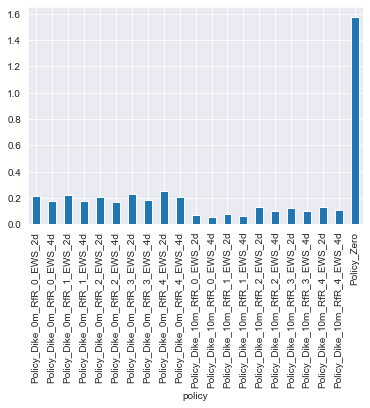

In [16]:
TCA_df["Expected Number of Deaths"]["mean"].plot.bar()

<AxesSubplot:xlabel='policy'>

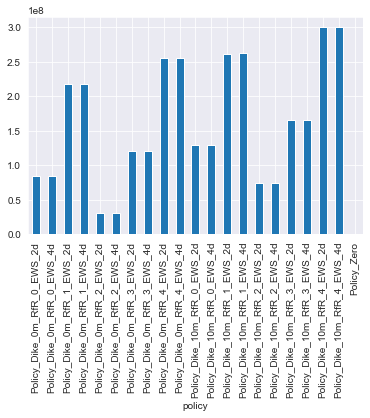

In [17]:
TCA_df["Total Costs"]["mean"].plot.bar()

<AxesSubplot:xlabel='policy'>

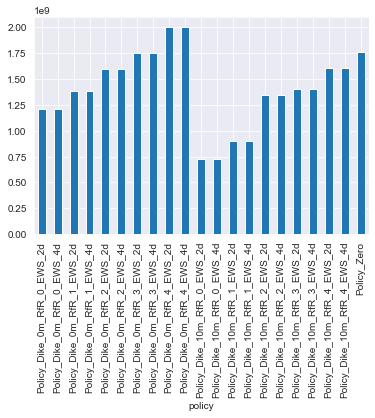

In [18]:
TCA_df["Cost plus Damage"]["mean"].plot.bar()